# Name: Jaswinder Singh
# Student ID: x19219997
# Module: Modelling, Simulation and Optimization (CA-1)
# Topic: Simulation of Traffic Flow to analyze the Vehicle bheaviour on a Multi-Lane Motorway using Simpy

Importing necessary packages

In [488]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random
import simpy
import simpy.events as evt

Defining the $\epsilon$ for comparing the small distances in the traffic simulation

In [344]:
ε = 0.00001
def isZero(x):
    return abs(x)<ε

Defining global variables - Units are defined in mks system [Need to be included into the vehicle class for the second task]

In [489]:
# Time tolerance: when at current speed difference a crash might occur within that number of seconds
CRITICAL_TIME_TOLERANCE = 4  # [s]   #Could be changed later if desired
LANE_CHANGE_TIME = 3 # [s]     # Maximum time it takes for a vehicle to change the lane
MIN_TIME_DIFF = 1      # Minimum difference in times to trigger overtaking

MIN_SPEED_DIFF = 2 # [m/s] min speed diff to trigger overtaking

CAR_LENGTH = 4 # [m]   

FAR_AWAY_IN_FRONT = 200 # [m]  distance at which a car in front can be ignored
FAR_AWAY_IN_BACK = 80   # [m]  distance at which a car behind can be ignored

# 1. Lanes --Defines the construction of different lane segments

In [490]:
# Assigning left lane as the slow lane and right lane as the fast lane
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [491]:
LANE_ID = 0

class Lane:
    
    ## some additional code
    def __init__(self, length, speedLimit):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
        
        self.length = length    # defines the lane length
        self.speedLimit = speedLimit    # defines the speed limit for the lane
        self.vehicles = []    # defines the vehicles on the lanes 
        
        self.next = None     # for the next lane segment
        self.prev = None     # for the previous lane segment
        
        # lane attached to the left/right
        self.left = None
        self.right = None
      
    # defines generic str() method for Lanes
    # extends the method with list of vehicles on the lane
    def __str__(self):
        l = "" if self.left is None else f" L:{self.left.id:d}"
        r = "" if self.right is None else f" R:{self.right.id:d}"
        vs = "" if len(self.vehicles)==0 else " "
        for v in self.vehicles:
            vs += str(v)
        return f"[{self.id:d} {int(self.length):d}m"+l+r+vs+"]" + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):        # this function defines the slow and fast lanes. Left lane is considered as the slow lane which is used by majority 
        if direction=='slow':             # of the vehicles and the right lane is considered as the fast lane which is used by only a small fraction of the
            return self.left              # vehicles.
        elif direction=='fast':
            return self.right
        else:
            return None

    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
     
    # constructs a number of lane segments of the same length and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    # constructs a number of lane segments of the same length and attaches them to the left
    def widenLeft(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
        
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.prev = l
        return self
    
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    ## additional code
    ## new generalised access method needed to calculate sideway view
    ## returns all vehicles between pos+distFrom and pos+distTo
    def at(self, pos, distFrom = -CAR_LENGTH/2, distTo = CAR_LENGTH/2):
        # make sure that the position of all cars is accurate at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key = lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if pos+distFrom < v.pos and v.pos < pos+distTo:     # checks the front and behind distance of the vehicles in terms of the car length defined earlier
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if pos+distTo > self.length and self.next is not None:
            res = res + self.next.at(0, distFrom=0, distTo=distTo-(self.length-pos))
        if pos+distFrom < 0 and self.prev is not None:
            res = self.prev.at(self.prev.length, distFrom=pos+distFrom, distTo=0) + res
        return res
        
    def inFront(self, pos, far=FAR_AWAY_IN_FRONT):
        # make sure that the position of all cars is accurate at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None     
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far=far-(self.length-pos))
        
    def behind(self, pos, far=FAR_AWAY_IN_BACK):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lane
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far=far-pos)
        
    def enter(self, vehicle, pos=0):      #defines the enter event for the vehicle
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane")

    def leave(self, vehicle):             #defines the leave lane event for the vehicle
        vehicle.rec.record(vehicle, event="leave lane")
        vehicle.lane = None
        # in the meantime the vehicle may have have moved
        # to one of the next lane segments...
        lane = self
        while lane is not None:
            if vehicle in lane.vehicles:
                lane.vehicles.remove(vehicle)
                break
            else:
                lane = lane.next

### 1.1 Test the construction of motorway

A single two lane 3km long motorway segment

In [492]:
VMAX = 120/3.6   #metres/second
LANE_ID = 0
l = Lane(3000, VMAX)     # For a single long segment of 3kms to avoid crashes. As advised by Christian#(See the lecture recording)
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 3000m R:1]
Right Lane: [1 3000m L:0]


A motorway made up of little segments - A 3km two lane motorway made of 1000 m segments

In [494]:
LANE_ID = 0
VMAX = 130/3.6   
l = Lane(1000, VMAX)
while l.totalLength()<3000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 1000m R:3]-[1 1000m R:4]-[2 1000m R:5]
Right Lane: [3 1000m L:0]-[4 1000m L:1]-[5 1000m L:2]


A motorway made up of little segments - A 3km motorway made up of two 1500m segments

In [495]:
LANE_ID = 0
VMAX = 130/3.6
l = Lane(1500, VMAX)
while l.totalLength()<3000:
    l.extend(Lane(1500, VMAX))
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 1500m R:2]-[1 1500m R:3]
Right Lane: [2 1500m L:0]-[3 1500m L:1]


# 2. VEHICLES -- defines the behaviour of vehicles

In [496]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [803]:
VEHICLE_ID = 0
# Basically, vehicle class contains properties of vehicles like position, velocity, acceleration and rate of acceleration
class Vehicle:
    def __init__(self, env, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[], Min_Time_Diff=1, Min_Speed_Test = 2, Car_Length = 4,
                 Far_Away_In_Front = 200, Far_Away_In_Back = 80,
                 Lane_Change_time=3, a_min=-4, a_max=2.5):
        
        global VEHICLE_ID   # Each vehicle is characterised by its VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1

        
        self.Lane_Change_time = Lane_Change_time # [s]
        self.a_min = a_min # [m/s²]
        self.a_max = a_max # [m/s²] corresponds to 0-100km/h om 12s
        self.Min_Time_Diff = Min_Time_Diff
        self.Min_Speed_Test = Min_Speed_Test # [m/s] min speed diff to trigger overtaking
        self.Car_Length = Car_Length # [m]
        self.Far_Away_In_Front = Far_Away_In_Front # [m]  distance at which a car in front can be ignored
        self.Far_Away_In_Back = Far_Away_In_Back   # [m]  distance at which a car behind can be ignored
        
        self.env = env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        ## second lane reference during changing of lanes
        self.oldLane = None
            
        self.t0 = t0       #Initial time when the process starts
        self.x0 = x0       #Initial position of the vehicle
        self.dx0 = dx0     #Initial velocity of the vehicle
        self.ddx0 = ddx0    #Initial accelaration of the vehicle
        self.dddx0 = dddx0   # Initial rate of acceleration of the vehicle
         
        self.t = t     # Time profile of the vehicles (don't know how exactly that works)
        self.v = v     #Velocty profile of the vehicles (Should be replaced with the random speee generator funstion later)
        self.t_target = []   
        self.v_target = []    #target velocity of the vehicle
        
        self.running = False
        self.crashed = False
        self.braking = False
        self.changingLane = False
        
        self.processRef = None
        self.env.process(self.process())
        
        ## this allows to trigger trace messages for
        ## the new feature Surround
        self.traceSurround = False
        self.traceOvertake = False
        self.traceBrake = False
    
    def __str__(self):
        return f"({self.id:d})"         
    
    #Returns true if there is no vehicle going faster than the other vehicle. Here other vehicle refers to all the 
     # other vehicle other than the point of reference vehicle
    def isNotFasterThan(self, other):     
        return True if other is None else self.dx0 <= other.dx0
     
    #Returns true if there is no vehicle going slower than the other vehicle. Here other vehicle refers to all the 
     # other vehicle other than the point of reference vehicle
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    def updateOnly(self):
        if self.crashed:
            return False
        t = self.env.now
        if t < self.t0:
            return False
        if self.running and t > self.t0:      # Euler integration for finding the position, velocity and accelaration
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = round(self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2,4)
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx  #Result of Euler integration returns time, position, 
                                                                   # velocity and acceleration
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.rec.record(self, event='end')     #Record the end event when the nextLane is none i.e when there is
                    self.running = False                   # no lane ahead
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
                    if self.oldLane is not None:
                        self.oldLane = self.oldLane.next
        return True
        
    def update(self):
        active = self.updateOnly()
        if not active:
            return False
        
        self.surround = Surround(self)   # Surround class is defined in the next cell.
        
        ## instead of direct link, call method
        inFront = self.surround.front
        if (isRunning(inFront) or isCrashed(inFront)) \
               and inFront.x0 < self.x0 + CAR_LENGTH:
            self.crash(inFront)
            return True

        if inFront is not None and not self.braking and \
                self.dx0 > inFront.dx0 and \
                self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0 > inFront.x0:
            Δt = max(MIN_TIME_DIFF, (inFront.x0-self.x0)/self.dx0)
            self.setTarget(Δt, inFront.dx0)
            self.interruptProcess()
            return True
        
        ## new code: start overtaking maneuver by changing into fast lane
        if inFront is not None and \
                not self.braking and not self.changingLane and \
                self.dx0 > inFront.dx0 + MIN_SPEED_DIFF and \
                self.x0 + (LANE_CHANGE_TIME+CRITICAL_TIME_TOLERANCE)*self.dx0 > inFront.x0 and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} overtakes v{inFront.id:d} at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'fast')
            self.interruptProcess()
            return True
            
        ## new code: end overtaking by returning to slow lane
        if self.surround.leftLane is not None and \
                not self.braking and not self.changingLane and \
                self.surround.left is None and \
                self.isNotFasterThan(self.surround.leftFront) and \
                self.surround.leftBack is None:
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} returns to slow lane at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'slow')
            self.interruptProcess()
            return True
     
    def setTarget(self, Δt, v):
        self.t_target = [ Δt ] + self.t_target
        self.v_target = [ v ] + self.v_target
      
    def process(self):  

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = env.now
        self.running = True
        self.rec.startRecording(self)
        self.startingLane.enter(self, pos=self.startingPos)
        
        while self.running:
            self.updateOnly()
            
            self.surround = Surround(self)

            inFront = self.surround.front
            if inFront is not None:
                
                # if the car in front is slower and we are a bit too near on its heals...
                if inFront.dx0 < self.dx0 and \
                        inFront.x0 < self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0:
                    if self.traceBrake:
                        print(f"t={self.t0:7,.1f}s Braking v{self.id:d} v={self.dx0:4.4f}m/s to {inFront.dx0:4.4f}")


                    yield from self.emergencyBraking(inFront.dx0)
                    if not isZero(self.dx0-inFront.dx0):
                        # after emergency breaking adjust to the speed of the car in front...
                        Δt = 2
                        self.setTarget(Δt, inFront.dx0)
                    continue 
        
            if len(self.t_target)==0:
                self.t_target = self.t.copy()
                self.v_target = self.v.copy()
                
            if len(self.t_target)>0:
                
                ## add code for explicit change of lane
                if type(self.v_target[0]) is str:
                    direction = normaliseDirection(self.v_target[0])
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(direction, t)
                
                else:
                    v0 = self.dx0
                    v1 = self.v_target[0]
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if isZero(v1-v0):
                        yield from self.wait(t)
                    else:
                        yield from self.adjustVelocity(v1-v0, t)
            else:
                yield from self.wait(10)
        
        self.rec.stopRecording(self)
  
    def emergencyBraking(self, v):   # defines the emergency braking procedure for vehicles
        
        def emergencyBrakingProcess(v):
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_min-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_min
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0

        
        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None
        self.braking = False
 
    ## make changeLane robust against interrupt:
    def changeLane(self, direction, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def changeLaneProcess(oldLane, newlane, Δt):
            self.updateOnly()
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            currentLane = self.lane
            self.oldLane.leave(self)
            self.lane = currentLane
            self.oldLane = None
            self.rec.record(self, 'done change '+direction)
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        self.updateOnly()
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        self.changingLane = True
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.updateOnly()
            #self.lane should now be newLane. However, it is possible that self.lane is already on the next lane segment
            # in which case newlane and oldLane need to be updated in sync:
            while self.lane != newLane and newLane is not None:
                newLane = newLane.next
                oldLane = oldLane.next
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4))
        self.changingLane = False

    def adjustVelocity(self, Δv, Δt):     # when two vehicles come closer than a certain distance, adjust velocity process is triggered
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            self.updateOnly()
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt     
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
            
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
        
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            self.dddx0 = 0
            pass
        self.processRef = None

    def wait(self, Δt):
         
        def waitProcess():
            yield self.env.timeout(Δt) 
        
        self.processRef = self.env.process(waitProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('change')
            
    def crash(self, other):    # function for recording the crash event
        
        def recordCrash(self):
            self.rec.record(self, 'crash')
            self.running = False
            self.crashed = True
            self.dx0 = 0
            self.ddx0 = 0
            self.dddx0 = 0
            
        if self.running:
            print(f"Crash p{self.id:d} into p{other.id:d} at t={self.t0:7.3f} x={self.x0:7.1f}")
            recordCrash(self)
            if other.running:
                recordCrash(other)       

# 3. Surround 

The Surround of a vehicle is a data structure that joins a number of properties and gives access to the next vehicles to the front, back, left and right side of the vehicle.

* `leftLane` and `rightLane` are references to next `Lane` and are `None` is there is no lane to the left or right. 
* `left` and `right` are Boolean values that indicate that there is a vehicle in the critical region or not.
* `front` (`leftFront`, `rightFront`) and `back` (`leftBack`, `rightBack`) are references to the `Vehicle` in the indicated region that is next to the current position. If there is no such vehicle, the references return `None`.
* The limits of the relevant regions are defined based on the current position +/- a number of car lengths +/- a distance that is a multiple of the current velocity, defined as time constants.

<img src='Surround.png' width=600/>

In [804]:
class Surround:
    
    def __init__(self, vehicle):
        
        def s(vehicle):
            if vehicle is None:
                return " "
            elif type(vehicle) is list:
                if len(vehicle)==1:
                    return s(vehicle[0])
                else:
                    res = "["
                    for v in vehicle:
                        if len(res)>1:
                            res += ','
                        res+=s(v)
                    res += "]"
                    return res
            else:
                return f"{vehicle.id:d}"
        
        # For each of the directions 'None' means that there is no vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected if something goes wrong
        
        self.leftBack = vehicle
        self.left = vehicle
        self.leftFront = vehicle
        self.back = vehicle
        self.vehicle = vehicle
        self.front = vehicle
        self.rightBack = vehicle
        self.right = vehicle
        self.rightFront = vehicle
        
        lane = vehicle.lane
        pos = vehicle.pos
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(pos)
            self.back = lane.behind(pos)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(pos)
                    self.rightBack = self.rightLane.behind(pos)
                else:
                    right = self.rightLane.at(pos)
                    if len(right)==0:
                        self.right = None
                    elif len(right)==1:
                        self.right = right[0]
                    else:
                        self.right = right

                    if self.right is None:
                        self.rightFront = self.rightLane.inFront(pos)
                        self.rightBack = self.rightLane.behind(pos)
                    else:
                        self.rightFront = None
                        self.rightBack = None
                
            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(pos)
                    self.leftBack = self.leftLane.behind(pos)
                else:
                    left = self.leftLane.at(pos)
                    if len(left)==0:
                        self.left = None
                    elif len(left)==1:
                        self.left = left[0]
                    else:
                        self.left = left
                        
                    if self.left is None:
                        self.leftFront = self.leftLane.inFront(pos)
                        self.leftBack = self.leftLane.behind(pos)
                    else:
                        self.leftFront = None
                        self.lefttBack = None
                    
        if vehicle.traceSurround:
            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# 4. Recorder

In [805]:
class SimpleRecorder:
    
    def __init__(self, env, startTime, stopTime, timeStep):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = env
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.vehiclesToTrace = []
        self.vehicles = []
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):       
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
        
    def startRecording(self, p):
        self.vehicles.append(p)
        
    def stopRecording(self, p):
        self.vehicles.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly():
                laneId = None if p.lane is None else p.lane.id
                oldLaneId = None if p.oldLane is None else p.oldLane.id
                if p.running or event!='timer':
                    ix = len(self.data)
                    self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, laneId, oldLaneId, p.pos, event] 
                    if event=='timer':
                        p.update()            
        else:
            for p in self.vehicles:
                self.record(p)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)

    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()
            yield self.env.timeout(self.timeStep)
            
    def plot(self, x, y, 
             vehicles=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(6, 4), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, '', data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            # use small circle to indicate emergency braking
            db = df[df.event=='brake']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
            
            # use black right pointing triangle
            # to indicate that a vehicle 
            # was changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black left pointing triangle
            # to indicate that a vehicle 
            # was changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
        plt.grid(True)

# 5. Verification of the classes and functions

5.1- Controlled Change of Lane -- for a 500m motorway. The 'R' in the list of v indicates the vehicle has to turn right

In [806]:
VMAX = 120/3.6    # m/s
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 10, 0.5)
l = Lane(500, VMAX)
r = Lane(500, VMAX)
l.attachRight(r)
v = Vehicle(env, rec, startingLane=l, dx0=20, t=[2, 2, 2, 2, 10], v=[20, 'R', 20, 20, 20])  # 'R' in the argument means the vehicle has to turn right
v.traceSurround=True
rec.run()

surround t=  0.00 || >0> | > > ||
surround t=  0.00 || >0> | > > ||
surround t=  0.50 || >0> | > > ||
surround t=  1.00 || >0> | > > ||
surround t=  1.50 || >0> | > > ||
surround t=  2.00 || >0> | > > ||
surround t=  2.00 || >0> | > > ||
surround t=  2.50 || >0> | >0> ||
surround t=  3.00 || >0> | >0> ||
surround t=  3.50 || >0> | >0> ||
surround t=  4.00 || > > | >0> ||
surround t=  4.00 || > > | >0> ||
surround t=  4.50 || > > | >0> ||
surround t=  4.50 || > > | >0> ||
surround t=  5.00 || >0> | >0> ||
surround t=  5.50 || >0> | >0> ||
surround t=  6.00 || >0> | >0> ||
surround t=  6.50 || >0> | >0> ||
surround t=  7.00 || >0> | >0> ||
surround t=  7.50 || >0> | > > ||
surround t=  7.50 || >0> | > > ||
surround t=  8.00 || >0> | > > ||
surround t=  8.50 || >0> | > > ||
surround t=  9.00 || >0> | > > ||
surround t=  9.50 || >0> | > > ||
surround t=  9.50 || >0> | > > ||
surround t= 10.00 || >0> | > > ||


In [807]:
rec.getData().head(10)

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,20,0,0,0,None,0,enter lane
1,0,0,20,0,0,0,None,0,timer
2,0.5,10.0,20.0,0.0,0,0,None,10.0,timer
3,1.0,20.0,20.0,0.0,0,0,None,20.0,timer
4,1.5,30.0,20.0,0.0,0,0,None,30.0,timer
5,2.0,40.0,20.0,0.0,0,0,None,40.0,timer
6,2,40.0,20.0,0.0,0,0,None,40.0,change fast
7,2,40.0,20.0,0.0,0,1,0,40.0,enter lane
8,2.5,50.12,20.5,1.0,0,1,0,50.12,timer
9,3.0,60.49,21.0,1.0,0,1,0,60.49,timer


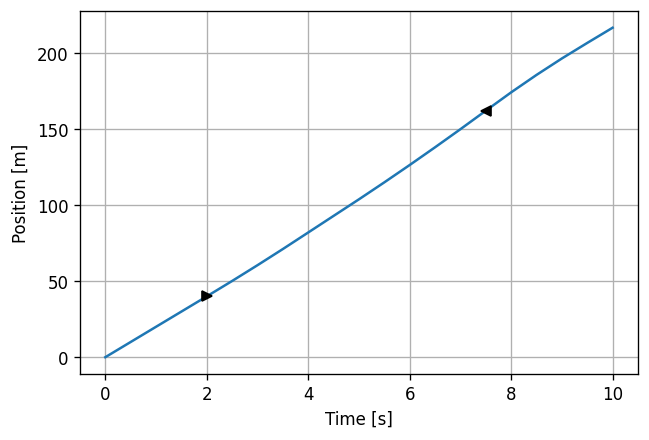

In [762]:
rec.plot('t','x')

5.2- Multiple Vehicles with fixed speed profile

In [808]:
VMAX = 20  # No need for conversion. Already in m/s
N = 50   # No. of vehicles
DT = 18 # time difference between start. DT is a constant and all the vehicles will have this constant difference in their arrival time
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)   # The simulation will run for 1000 seconds

l = Lane(3000, VMAX)
l.extend(Lane(3000, VMAX))
r = l.widenRight()
for i in range(N):
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=VMAX+3*i, t=[10], v=[VMAX+3*i])
    v.traceOvertake = True   # for tracing the overtaking events
    v.traceSurround - True
rec.run()                                                         

t=   85.0s Overtaking v1 overtakes v0 at x=1,541.0m
t=  142.0s Overtaking v3 overtakes v2 at x=2,552.0m
t=  149.0s Overtaking v2 overtakes v0 at x=2,888.1m
t=  159.0s Overtaking v1 returns to slow lane at x=3,262.5m
t=  190.0s Overtaking v5 overtakes v4 at x=3,500.0m
t=  191.0s Overtaking v4 overtakes v0 at x=3,720.9m
t=  230.0s Overtaking v6 overtakes v0 at x=4,499.4m
t=  233.0s Overtaking v2 returns to slow lane at x=5,064.3m
t=  234.0s Overtaking v5 returns to slow lane at x=4,763.0m
t=  253.0s Overtaking v8 overtakes v7 at x=4,796.0m
t=  267.0s Overtaking v8 returns to slow lane at x=5,431.5m
t=  269.0s Overtaking v3 returns to slow lane at x=5,969.9m


In [809]:
rec.getData().head()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,20,0,0,0,None,0,enter lane
1,0,0,20,0,0,0,None,0,timer
2,1,20.0,20.0,0,0,0,None,20.0,timer
3,2,40.0,20.0,0,0,0,None,40.0,timer
4,3,60.0,20.0,0,0,0,None,60.0,timer


In [810]:
VMAX = 30
N = 8
DT = 7 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 200, 1)
l = Lane(1000, VMAX)
l.extend(Lane(1000, VMAX))
r = l.widenRight()
for i in range(N):
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=10, t=[20, 20, 40, 20], v=[35-2*i, 35-2*i, 15-2*i, 15-2*i])
    v.traceOvertake = True
#    v.traceSurround = True
rec.run()

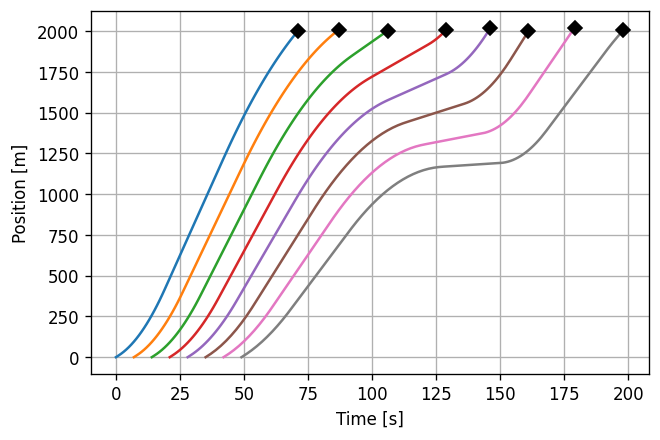

In [811]:
rec.plot('t', 'x')

In [767]:
rec.getEvents().head()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
8,7,0,10,0,1,0,None,0,enter lane
23,14,0,10,0,2,0,None,0,enter lane
45,21,0,10,0,3,0,None,0,enter lane
74,28,0,10,0,4,0,None,0,enter lane


5.3- Testing Vehicles with random speed profiles

In [768]:
SLOW_CYCLE = 100
def randomIntervals(cycles):
    # return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ] 
    return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]

In [769]:
times = randomIntervals(10)
times

[76.9791151964325,
 71.73641684827929,
 115.02616521972475,
 95.61894094409733,
 41.399548572980024,
 107.15760533818501,
 56.56954716295382,
 98.49940463205168,
 83.60917956507673,
 131.4190607387929]

In [770]:
SPEED_VARIATION = 0.05
def randomSpeedVariation(vmax, cycles, cv=SPEED_VARIATION):
    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ] 

In [771]:
speed = randomSpeedVariation(30,10)
speed

[30.185305492901904,
 28.769778415001056,
 31.682565594115577,
 29.782063127423445,
 30.359585607708997,
 28.82880460076298,
 31.747700062402206,
 27.402952053582357,
 30.375841491412128,
 28.651287134238228]

5.3.1- Single vehicle of varying speed

In [772]:
CYCLES = 6
VMAX = 120/3.6    #m/s
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)

#testing on a 4km motorway made of four 1kms segments
l = Lane(4000, VMAX)
while l.totalLength()<4000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()

times = randomIntervals(CYCLES)
speed = randomSpeedVariation(VMAX, CYCLES)
Vehicle(env, rec, startingLane=l, dx0=speed[-1], t=times, v=speed)
rec.traceOvertake = True
rec.run()

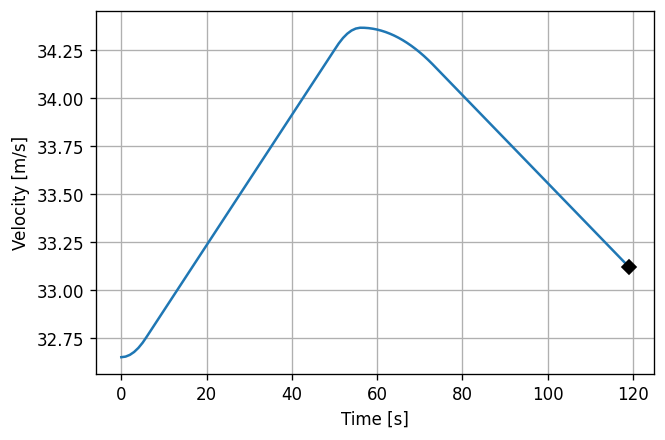

In [773]:
rec.plot('t','v')

In [774]:
rec.getData().head()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,32.652364,0,0,0,None,0,enter lane
1,0,0,32.652364,0,0,0,None,0,timer
2,1,32.65,32.655400,0.006026,0,0,None,32.65,timer
3,2,65.31,32.664400,0.012052,0,0,None,65.31,timer
4,3,97.98,32.679500,0.018078,0,0,None,97.98,timer


5.3.2- Multiple vehicles with varying speed

In [775]:
#Multiple Vehicles with varying speed
VMAX = 120/3.6
N = 5 # number of points
DT = 5 # time difference between start
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 4000, 1)

l = Lane(3000, VMAX)
while l.totalLength()<3000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()

print('l', l)
print('r', r)
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX+i, CYCLES)
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
    
rec.run()

l [0 3000m R:1]
r [1 3000m L:0]
t=   15.0s Overtaking v3 overtakes v2 at x=    0.0m
t=   50.0s Overtaking v2 overtakes v1 at x=1,359.2m
t=   96.0s Overtaking v2 returns to slow lane at x=2,987.2m


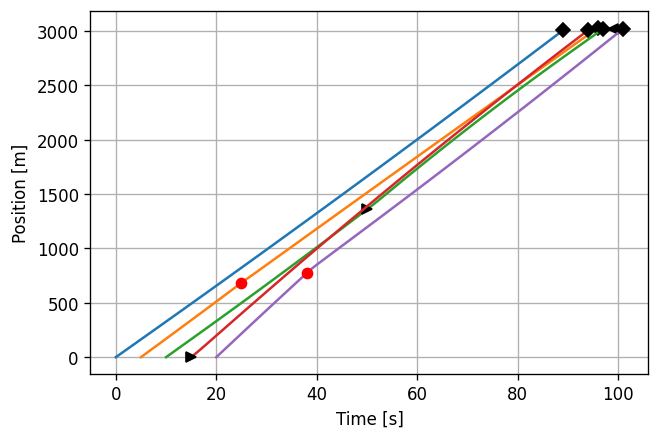

In [776]:
rec.plot('t', 'x')

5.4- Multiple vehicles with fixed speed

In [777]:
#Two vehicles with not enough distance between them
VMAX = 120/3.6     #m/s
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(2000, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane = l, t0=0, dx0=10)
Vehicle(env, rec, startingLane = l, t0=20, dx0=20)
rec.run()
# rec.traceSurround = True

In [778]:
rec.getData().head()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
1,0,0,10,0,0,0,None,0,timer
2,1,10.0,10.0,0,0,0,None,10.0,timer
3,2,20.0,10.0,0,0,0,None,20.0,timer
4,3,30.0,10.0,0,0,0,None,30.0,timer


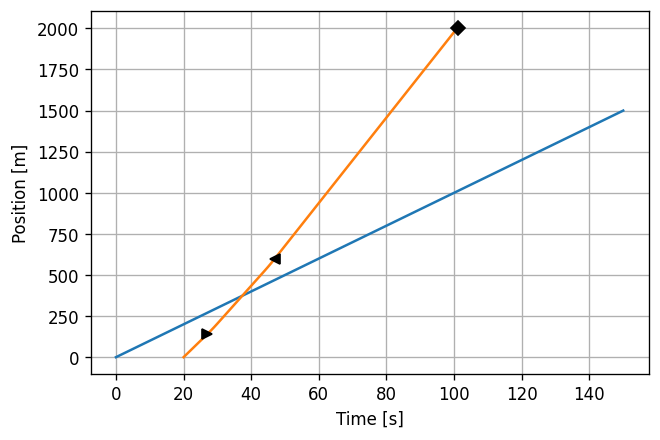

In [779]:
rec.plot('t','x')

In [780]:
# A large number of vehicles with not enough distance between them
VMAX = 120/3.6
N = 7
DT = 10 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
l = Lane(4000, VMAX)
r = l.widenRight()
for i in range(N):
    Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=10, t=[15, 30, 50], v=[25+2*i, 25+2*i, 15+2*i])
rec.run()

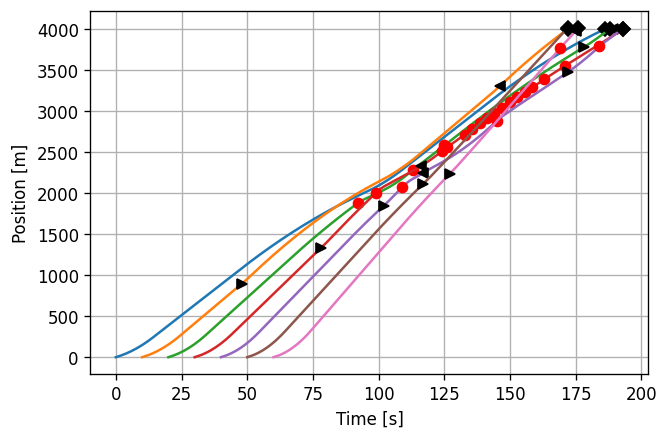

In [781]:
rec.plot('t', 'x')

5.5- Crash Scenario

In [782]:
#Crash scenario  -- only two vehicles
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(1000, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=r, t0=5, dx0=30)
rec.run()

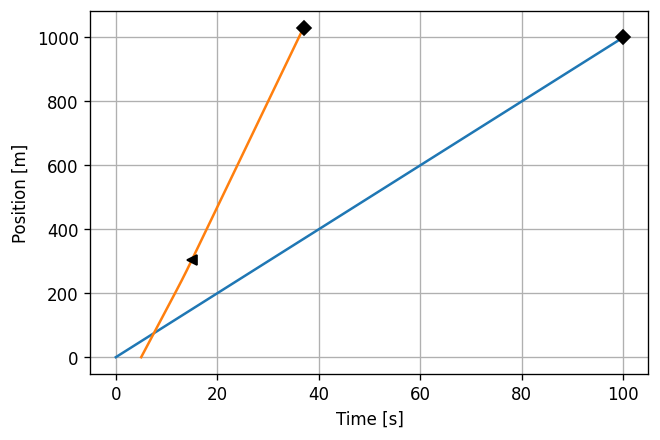

In [783]:
rec.plot('t','x')

In [784]:
# Crash scenario -- multiple vehicles
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(1500, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=l, t0=6, dx0=18)
Vehicle(env, rec, startingLane=l, t0=15, dx0=40)
Vehicle(env, rec, startingLane=l, t0=25, dx0=16)
rec.run()

Crash p1 into p2 at t= 20.000 x=  148.8


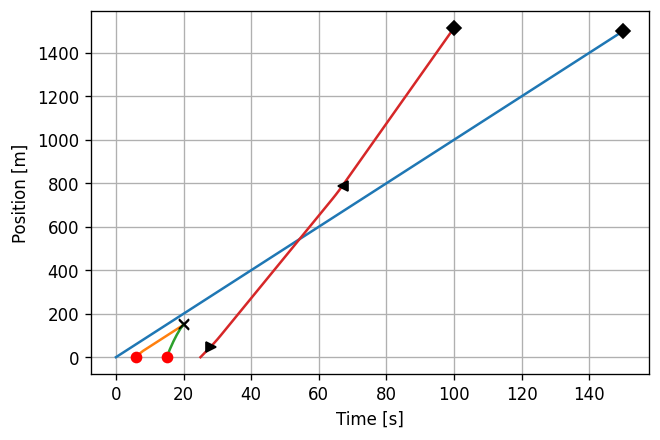

In [785]:
rec.plot('t','x')

In [786]:
rec.getData().head()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
1,0,0,10,0,0,0,None,0,timer
2,1,10.0,10.0,0,0,0,None,10.0,timer
3,2,20.0,10.0,0,0,0,None,20.0,timer
4,3,30.0,10.0,0,0,0,None,30.0,timer


5.6- Row of vehicles with varying speed (Random speeds)

In [789]:
VMAX = 120/3.6   # m/s
N = 100 # number of vehicles
DT = 10 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
l = Lane(3000, VMAX)                ### Row of Cars with Varying Speed
r = l.widenRight()
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=VMAX, t=times, v=speed)
    rec.traceOvertake = True
    rec.traceSurround = True
rec.run()

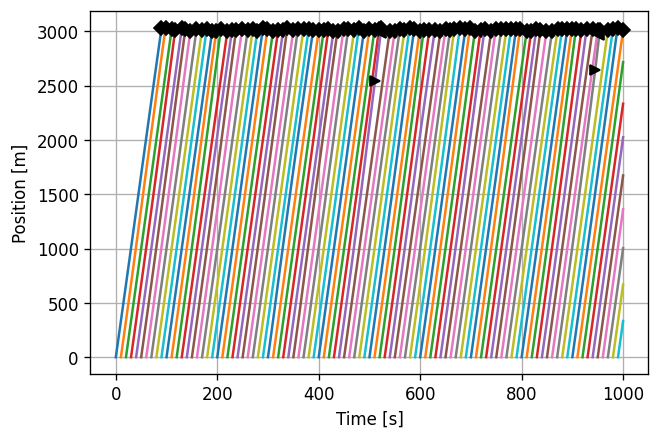

In [790]:
rec.plot('t','x')

CA tasks start here..............................................................................................................................

# CA Task 1: Simulation of a two lane motorway and calculation of throughput, average travelling time, average speed and traffic density

__Details__: The first task involves simulating a two lane motorway and then calculating the below mentioned quantities. For accomplishing this task, we have used the code provided in the class and added the following components to it:
* __chooseLane() method__: This function allows a vehicle to choose between the two lanes at random but with specific weights given to each lane. For the __left/slow lane__, we have given a weight of __0.80__ since majority of the vehicles will be starting from this lane only. The __right/fast lane__ is given a weight of __0.20__ since only a small fraction of incoming vehicles pass through this lane.
* We have used __different inter-arrival times__ for each of the two lanes __IAT_fast__ and __IAT_slow__. We ran different simulations with different values for the two inter-arrival times.
* A condition is added to the main simulation loop allowing vehicles starting from the left lane to use IAT\_fast and those starting from the right lane to use \textit{IAT\_slow}.
* For calculating the _iat_, a __uniform distribution__ has been used instead of an expovariate distribution to reduce the variation. Moreover, expovariate distribution generated a few extremely small values like 0.0048 for the inter-arrival time which caused crashes.

The following four quantities have been computed from the simulation dataframe.
* __Throughput__: Cumulative volume across all the lanes going in one direction measured and averaged over a prolonged period of time.
* __Average Travelling time__: Average time taken by a vehicle to cross the entire motorway.
* __Average Speed__: $\frac{\text{Length of the motorway}}{\text{Average travelling time}}$
* __Traffic density__: $\frac{\text{Throughput}}{\text{Average speed}}$

# CA Task 2: Simulation of a two lane motorway incorporating the human driving behaviour.

__Details__: The second task is an extension of the first task to simulate the human driving behaviour. In this task, we will be using the __freeMotorwaySpeed()__ function from the trafffic data generation file for generating the speed of the vehicles. Another aspect introduced to capture the real world scenario is the use of __chooseVehicle()__ method which randomly generates a vehicle type between electrical and diesel for the simulation. The minimum and maximum accelerations will be decided for the vehicle based on the choice generated(electrical or diesel).

# Task-1

### Defining the function for the choosing of the lanes

Since we have to choose the different inter-arrival times for each lane, we can also define a function that enables a vehicle to choose a specific lane based on the weights given in the random function. Here, I take the assumption that 80% of the vehicles that enter the simulation will take the slow lane (left) and the rest 20% will take the fast lane (right).

In [585]:
def chooseLane(laneList):
    lane = random.choices(laneList, [0.80, 0.20])[0]
    
    return lane

In [586]:
#Checking if the function works correctly
choice = [chooseLane(['l', 'r']) for i in range(50)]
print(choice)

['l', 'l', 'l', 'l', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'r', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'l', 'r', 'l', 'r', 'r', 'l', 'r', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'l', 'l', 'l', 'r', 'l']


Checking the ranges of the distributions used for calculating inter-arrival time

In [587]:
#Expovariate distribution
IAT = 18
iat_e = [ random.expovariate(1.0/IAT) for i in range(3000) ]
print(max(iat_e), min(iat_e))

140.2108409657023 0.01015514620349752


In [588]:
#Normal distribution
IAT = 20
iat_u = [random.uniform(IAT/10, IAT+10) for i in range(3000)]
print(max(iat_u), min(iat_u))

29.999528057788982 2.0068813787684783


Defining the function for choosing IATs based on lanes

In [589]:
# IAT_slow = 13  #Average interarrival time for the slow lane
# IAT_fast = 10   #Average interarrival time for the fast lane
def chooseIAT(choice):
    if choice == 'l':
        IAT = IAT_slow
    else:
        IAT = IAT_fast
    return IAT

In [590]:
IAT_slow = 13  #Average interarrival time for the slow lane
IAT_fast = 10   #Average interarrival time for the fast lane
IAT_final = [chooseIAT(choice[i]) for i in range(10)]
IAT_final # Funciton Works 

[13, 13, 13, 13, 13, 10, 13, 10, 13, 10]

In [581]:
chooseIAT('l')

13

In [591]:
chooseIAT('r')

10

Running the simulation using above functions

1. Using single inter-arrival time value for both lanes with uniform distribution

In [740]:
VMAX = 120/3.6
N = 3000 # number of points 
IAT =  5# average interarrival time    
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1800, 1)
#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]
iat = [random.uniform(IAT/10, IAT+10) for i in range(N)]
l = Lane(3000, VMAX)
r = l.widenRight()

t0 = 0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat[i]
    v = Vehicle(env, rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
rec.run()

t=  131.0s Overtaking v8 overtakes v7 at x=2,281.8m
t=  139.0s Overtaking v10 overtakes v9 at x=2,252.1m
t=  148.0s Overtaking v8 returns to slow lane at x=2,908.8m
t=  156.0s Overtaking v10 returns to slow lane at x=2,897.6m
t=  200.0s Overtaking v19 overtakes v18 at x=2,307.3m
t=  216.0s Overtaking v19 returns to slow lane at x=2,905.1m
t=  246.0s Overtaking v25 overtakes v24 at x=1,398.5m
t=  248.0s Overtaking v28 overtakes v27 at x=  645.8m
t=  270.0s Overtaking v33 overtakes v32 at x=   14.0m
t=  290.0s Overtaking v25 returns to slow lane at x=2,979.8m
t=  397.0s Overtaking v49 overtakes v48 at x=  168.1m
t=  435.0s Overtaking v57 overtakes v56 at x=   12.8m
t=  444.0s Overtaking v47 overtakes v46 at x=2,106.9m
t=  445.0s Overtaking v49 returns to slow lane at x=1,888.8m
t=  465.0s Overtaking v58 overtakes v56 at x=  941.5m
t=  467.0s Overtaking v47 returns to slow lane at x=2,966.0m
t=  509.0s Overtaking v58 returns to slow lane at x=2,408.1m
t=  601.0s Overtaking v76 overtakes v

In [741]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event
0,4.255623,0,35.557611,0,0,0,None,0,enter lane
1,5.000000,26.47,35.558300,0.001977,0,0,None,26.47,timer
2,6.000000,62.03,35.561600,0.004632,0,0,None,62.03,timer
3,7.000000,97.59,35.567600,0.007288,0,0,None,97.59,timer
4,8.000000,133.16,35.576200,0.009944,0,0,None,133.16,timer
...,...,...,...,...,...,...,...,...,...
22667,1800.000000,756.82,34.243300,0.028964,239,0,None,756.82,timer
22668,1800.000000,648.71,33.928400,0.01331,240,0,None,648.71,timer
22669,1800.000000,565.48,32.950300,0.010764,241,0,None,565.48,timer
22670,1800.000000,273.69,33.589300,0.023273,242,0,None,273.69,timer


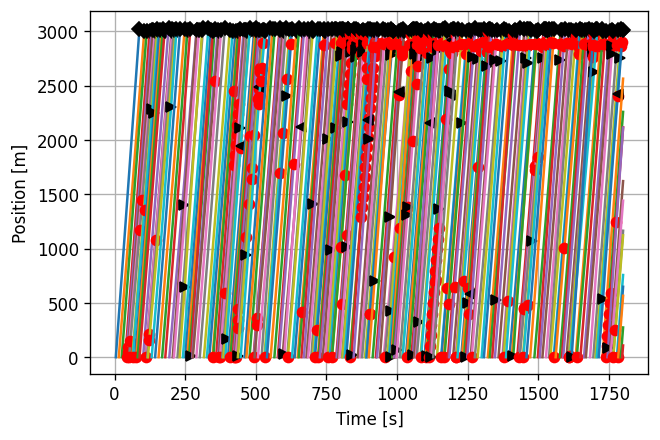

In [742]:
rec.plot('t','x')

### Average Travelling Time and Speeds

Method- 1

In [743]:
df = rec.getData()

In [744]:
enter_lane_df = rec.getData().loc[rec.getData().event == 'enter lane']
enter_lane_df = enter_lane_df.groupby(['id', 'event'])['t']
# enter_lane_df.describe()
end_df = rec.getData().loc[rec.getData().event == 'end']
end_df = end_df.groupby(['id', 'event'])['t']
# end_df.describe()
time_diff_df = pd.merge(left = enter_lane_df.describe(), right = end_df.describe(), on = 'id', how = 'inner', suffixes = ('_enter_lane', '_end_lane'))
time_diff_df.head()

,count_enter_lane,mean_enter_lane,std_enter_lane,min_enter_lane,25%_enter_lane,50%_enter_lane,75%_enter_lane,max_enter_lane,count_end_lane,mean_end_lane,std_end_lane,min_end_lane,25%_end_lane,50%_end_lane,75%_end_lane,max_end_lane
id,,,,,,,,,,,,,,,,
0,1.0,4.255623,NaN,4.255623,4.255623,4.255623,4.255623,4.255623,1.0,88.00000,NaN,88.00000,88.00000,88.00000,88.00000,88.00000
1,1.0,14.691864,NaN,14.691864,14.691864,14.691864,14.691864,14.691864,1.0,105.00000,NaN,105.00000,105.00000,105.00000,105.00000,105.00000
2,1.0,25.111052,NaN,25.111052,25.111052,25.111052,25.111052,25.111052,1.0,113.80592,NaN,113.80592,113.80592,113.80592,113.80592,113.80592
3,1.0,37.926426,NaN,37.926426,37.926426,37.926426,37.926426,37.926426,1.0,124.00000,NaN,124.00000,124.00000,124.00000,124.00000,124.00000
4,1.0,41.119427,NaN,41.119427,41.119427,41.119427,41.119427,41.119427,1.0,131.00000,NaN,131.00000,131.00000,131.00000,131.00000,131.00000


In [745]:
avg_time_diff = time_diff_df['min_end_lane'] - time_diff_df['min_enter_lane']
Avg_tt = avg_time_diff.mean()
print('Average Travelling Time =', Avg_tt)

Average Travelling Time = 90.3553481568357


In [746]:
Avg_speed_1 = l.totalLength()/Avg_tt
print('Average Speed', Avg_speed, 'm/s')

Average Speed 33.202240500392996 m/s


Method- 2

In [747]:
def Average_tt():
    ids = df.id.unique()
    tt = []
    for j in ids:
        df_id = df[df['id'] == j]
        start = df_id[df_id['event'] == "enter lane"]
        end = df_id[df_id['event'] == "end"]
        if(len(end.index)!=0):
            tt.append(end.iloc[-1]['t'] - start.iloc[0]['t'])
    return tt

In [748]:
travelling_time = Average_tt()
A_tt = sum(travelling_time) / len(travelling_time)
print('Average Travelling Time =', A_tt)

Average Travelling Time = 90.3553481568357


In [749]:
Avg_speed_2 = l.totalLength()/A_tt
print('Average Speed', Avg_speed, 'm/s')

Average Speed 33.202240500392996 m/s


### Throughput

In [750]:
def throughput():
    leave_ln = df[df.event == 'end']
    ll = leave_ln.groupby(['id'])
    leave_ln_final = ll.last().sort_index().reset_index()
    T_min = leave_ln.t.min()
    T_max = leave_ln.t.max()
    no_of_vehicles = len(leave_ln)
    Throughput = (no_of_vehicles/(T_max - T_min))*3600
    return Throughput
print('Throughput in cars/hours = ', throughput())

Throughput in cars/hours =  485.7476635514019


### Traffic Density

In [751]:
Traffic_density = Throughput/Avg_speed_1
print('Traffic Density = ', Traffic_density)

Traffic Density =  6.745795691525602


# Task-2 

Introducing the freemotorwaySpeed() function

In [696]:
#Introducing the freemotorway speed function() to calculate the speeds of the vehicles
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01, 0.003])

def random_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(quantiles)):
        if u<quantiles[i+1]:
            p = (u-quantiles[i])/(quantiles[i+1]-quantiles[i])
            return free_speed[i]*p+free_speed[i+1]*(1-p)

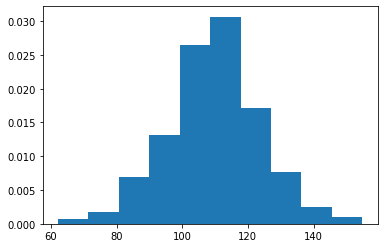

In [697]:
#Checking the distribution of speeds
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
hist = plt.hist(speeds, bins=10, density=True)

This simple approach generates however a stepwise distribution function, which may have undesired side effects for large sample sets, as we can see in this example:

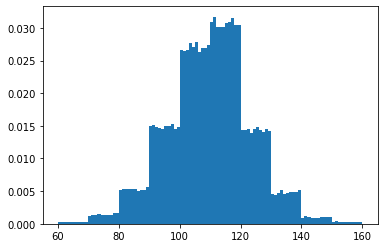

In [698]:
random.seed(0)
speeds = [ random_speed() for i in range(100000)]
hist = plt.hist(speeds, bins=100, density=True)

In [699]:
# We now define the gaussian kernel that matches the distribution
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
kernel = stats.gaussian_kde(speeds)

In [700]:
vel = np.arange(30, 191)
q = [ kernel.integrate_box_1d(30, i) for i in vel ]

def freeMotorwaySpeed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(q)):
        if u<q[i+1]:
            p = (u-q[i])/(q[i+1]-q[i])
            # return (free_speed[i+1]+free_speed[i])/2*p+(1-p)*(free_speed[i+1]+free_speed[i+2])/2
            return vel[i]*p + vel[i+1]*(1-p)

In [701]:
random.seed(0)
rspeeds = [ freeMotorwaySpeed() for i in range(100000) ]

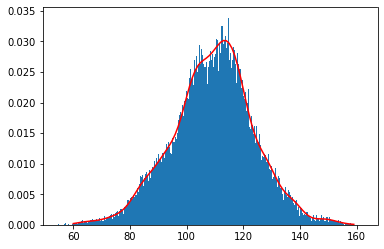

In [702]:
#Checking the distribution of freemotorway function
h = plt.hist(rspeeds, bins=1000, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')

Checking the ranges of the expovariate and the uniform distribution

In [703]:
IAT = 18
iat_e = [ random.expovariate(1.0/IAT) for i in range(3000) ]
print(max(iat_e), min(iat_e))

155.3055767808769 0.004485859854781841


In [704]:
IAT = 20
iat_u = [random.uniform(IAT/10, IAT+10) for i in range(3000)]
print(max(iat_u), min(iat_u))

29.990512481213685 2.024546399521641


Incorporating chooseLane(), chooseIAT() and freeMotorwaySpeed() into simulation

In [832]:
VMAX = 120/3.6
N = 2000
IAT_slow = 18 #Average interarrival time for the slow lane
IAT_fast = 13  #Average interarrival time for the fast lane
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 3000, 1)
random.seed(42)
lane_choice = [chooseLane([l, r]) for i in range(N)]
iat_slow = [random.uniform(IAT_slow/10, IAT_slow+10) for i in range(N)]
iat_fast = [random.uniform(IAT_fast/10, IAT_slow+10) for i in range(N)]
l = Lane(3000, VMAX)
r = l.widenRight()

t0 = 0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = [freeMotorwaySpeed()/3.6 for i in range(N)]   #Using the free motorway speed function to generate the speeds
    lane_choice = chooseLane([l, r]) 
    
    if lane_choice == r:
        t0 += iat_fast[i]
        v = Vehicle(env, rec, startingLane = lane_choice, t0=t0, dx0=speed[-1], t=times, v=speed)
    elif lane_choice == l:
        t0 += iat_slow[i]
        v = Vehicle(env, rec, startingLane = lane_choice, t0=t0, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
#     v.traceSurround = True
rec.run()

t=    5.0s Overtaking v0 returns to slow lane at x=   15.9m
t=   62.0s Overtaking v2 returns to slow lane at x=1,102.4m
t=  112.0s Overtaking v7 returns to slow lane at x=   15.8m
t=  139.0s Overtaking v5 overtakes v4 at x=2,513.3m
t=  146.0s Overtaking v10 returns to slow lane at x=   26.6m
t=  151.0s Overtaking v5 returns to slow lane at x=2,955.8m
t=  175.0s Overtaking v9 overtakes v8 at x=1,157.6m
t=  180.0s Overtaking v12 returns to slow lane at x=    4.6m
t=  188.0s Overtaking v12 overtakes v11 at x=  314.5m
t=  221.0s Overtaking v9 returns to slow lane at x=2,829.5m
t=  256.0s Overtaking v12 returns to slow lane at x=2,740.5m
t=  282.0s Overtaking v19 returns to slow lane at x=    7.1m
t=  286.0s Overtaking v16 overtakes v15 at x=1,423.3m
t=  330.0s Overtaking v16 returns to slow lane at x=2,946.9m
t=  339.0s Overtaking v21 returns to slow lane at x=1,247.8m
t=  346.0s Overtaking v19 overtakes v18 at x=2,390.1m
t=  358.0s Overtaking v22 overtakes v20 at x=1,503.8m
t=  421.0s Ove

In [833]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event
0,4.437688,0,28.304996,0,0,1,None,0,enter lane
1,5.000000,15.92,28.306700,0.00621,0,1,None,15.92,timer
2,5.000000,15.92,28.306700,0.00621,0,1,None,15.92,change slow
3,5.000000,15.92,28.306700,0.00621,0,0,1,15.92,enter lane
4,6.000000,44.73,29.306700,1,0,0,1,44.73,timer
...,...,...,...,...,...,...,...,...,...
20005,3000.000000,2204.33,25.452000,-0.084943,189,0,None,2204.33,timer
20006,3000.000000,1693.64,29.373500,-0.030166,190,0,None,1693.64,timer
20007,3000.000000,1217.19,29.504400,-0.004358,191,0,None,1217.19,timer
20008,3000.000000,484.69,33.464900,-0.250449,192,0,None,484.69,timer


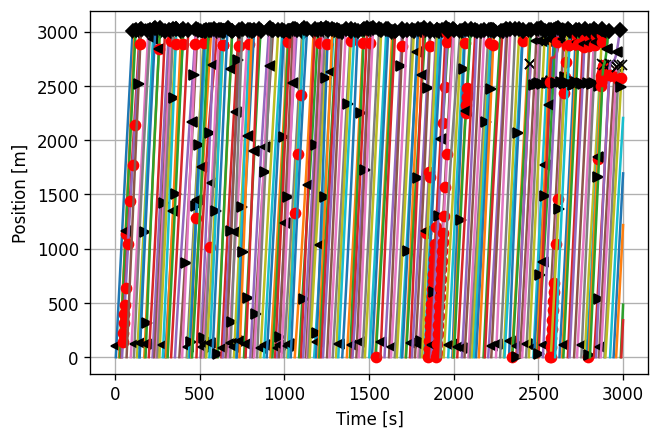

In [834]:
rec.plot('t', 'x')

In [835]:
df = rec.getData()

## Average travelling time and speeds

In [836]:
travelling_time = Average_tt()
A_tt = sum(travelling_time) / len(travelling_time)
print('Average Travelling Time =', A_tt)

Average Travelling Time = 97.71498158680153


In [838]:
Avg_speed_2 = l.totalLength()/A_tt
print('Average Speed', Avg_speed_2, 'm/s')

Average Speed 30.701535744905808 m/s


## Throughput

In [839]:
Throughput = throughput()
print('Throughput in cars/hours = ', Throughput)

Throughput in cars/hours =  223.97553091654794


## Traffic Density

In [840]:
Traffic_density = Throughput/Avg_speed_1
print('Traffic Density = ', Traffic_density)

Traffic Density =  6.745795691525602


Varying speed and interarrival times - using expovariate distribution for calculating inter-arrival time and randomSpeedvariation function for velocities

In [791]:
VMAX = 120/3.6
N = 2000 # number of points 
IAT =  18# average interarrival time    
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1800, 1)
iat = [ random.expovariate(1.0/IAT) for i in range(N) ]
# iat = [random.uniform(IAT/10, IAT+10) for i in range(500)]
l = Lane(3000, VMAX)
r = l.widenRight()
print('l', l)
print('r', r)
t0 = 0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat[i]
    v = Vehicle(env, rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
#     v.traceSurround = True
rec.run()

l [0 3000m R:1]
r [1 3000m L:0]
t=  206.0s Overtaking v12 overtakes v11 at x=2,019.6m
t=  230.0s Overtaking v12 returns to slow lane at x=2,925.5m
t=  534.0s Overtaking v26 overtakes v25 at x=2,597.2m
t=  541.0s Overtaking v26 returns to slow lane at x=2,855.4m
t=  606.0s Overtaking v31 overtakes v30 at x=1,816.8m
t=  636.0s Overtaking v31 returns to slow lane at x=2,896.3m
t=  648.0s Overtaking v35 overtakes v34 at x=2,186.0m
t=  668.0s Overtaking v35 returns to slow lane at x=2,923.0m
t=  837.0s Overtaking v48 overtakes v47 at x=   32.0m
t=  910.0s Overtaking v48 returns to slow lane at x=2,622.4m
Crash p48 into p47 at t=911.000 x= 2657.2
t=  920.0s Overtaking v49 overtakes v48 at x=2,492.8m
t=  927.0s Overtaking v49 returns to slow lane at x=2,758.1m
t=  931.0s Overtaking v55 overtakes v54 at x=1,174.8m
t=  936.0s Overtaking v50 overtakes v48 at x=2,462.5m
t=  944.0s Overtaking v50 returns to slow lane at x=2,757.4m
t=  945.0s Overtaking v51 overtakes v48 at x=2,464.5m
t=  950.0s Ov

In [794]:
df = rec.getData()
df.head()

,t,x,v,a,id,lane,oldLane,pos,event
0,5.39579,0,31.536818,0,0,0,None,0,enter lane
1,6.00000,19.06,31.545800,0.029723,0,0,None,19.06,timer
2,7.00000,50.63,31.600100,0.078917,0,0,None,50.63,timer
3,8.00000,82.28,31.703600,0.12811,0,0,None,82.28,timer
4,9.00000,114.06,31.848800,0.150028,0,0,None,114.06,timer


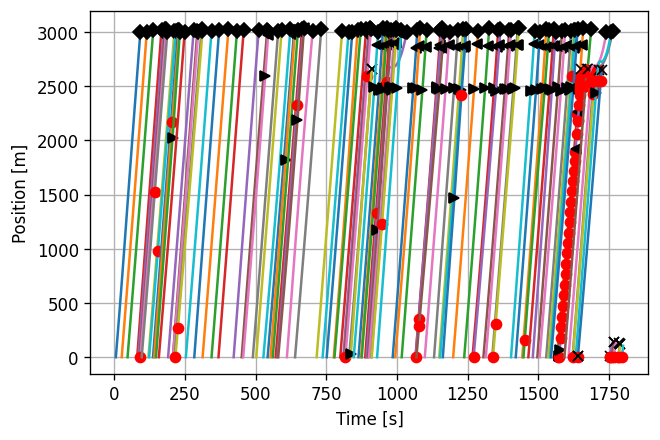

In [795]:
rec.plot('t', 'x')

In [796]:
Throughput = throughput()
print('Throughput in cars/hours = ', Throughput)

Throughput in cars/hours =  202.5491674621294


In [798]:
travelling_time = Average_tt()
A_tt = sum(travelling_time) / len(travelling_time)
print('Average Travelling Time =', A_tt)

Average Travelling Time = 91.65743588886406


In [800]:
Avg_speed_3 = l.totalLength()/A_tt
print('Average Speed', Avg_speed_3, 'm/s')

Average Speed 32.73056867571053 m/s


Incorporating the different vehicle types

In [820]:
def chooseVehicle(VehicleList):
    vehicle = random.choices(VehicleList, [0.80, 0.20])[0]
    return vehicle

In [821]:
choice_v = [chooseVehicle(['electrical', 'diesel']) for i in range(20)]
print(choice_v)

['electrical', 'electrical', 'electrical', 'electrical', 'electrical', 'electrical', 'electrical', 'electrical', 'electrical', 'diesel', 'electrical', 'electrical', 'electrical', 'electrical', 'diesel', 'electrical', 'electrical', 'electrical', 'electrical', 'electrical']


Running the simulation

In [825]:
VMAX = 120/3.6
N = 2000
IAT = 5
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 3000, 1)
random.seed(42)
vehicle_choice = [chooseVehicle([electrical, diesel]) for i in range(2000)]
iat = [random.uniform(IAT/10, IAT+10) for i in range(N)]
l = Lane(3000, VMAX)
r = l.widenRight()

t0 = 0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = [freeMotorwaySpeed()/3.6 for i in range(N)]   #Using the free motorway speed function to generate the speeds
    vehicle_choice = chooseVehicle([electrical, diesel]) 
    
    if vehicle_choice == electrical:
        a_min_el = -5
        a_max_el = 8
        v = Vehicle(env, rec, startingLane = l, t0=t0, dx0=speed[-1], t=times, v=speed, a_min = a_min_el, a_max = a_max_el)
    elif vehicle_choice == diesel:
        a_min_d = -4
        a_max_d = 2.5
        v = Vehicle(env, rec, startingLane = lane_choice, t0=t0, dx0=speed[-1], t=times, v=speed, a_min = a_min_d, a_max = a_max_el)
    v.traceOvertake = True
#     v.traceSurround = True
rec.run()

t=   47.0s Overtaking v3 returns to slow lane at x=   30.0m
t=   91.0s Overtaking v6 returns to slow lane at x=    8.3m
t=  109.0s Overtaking v4 overtakes v3 at x=1,715.5m
t=  130.0s Overtaking v9 returns to slow lane at x=   16.1m
t=  138.0s Overtaking v4 returns to slow lane at x=2,725.5m
t=  153.0s Overtaking v9 overtakes v8 at x=  842.5m
t=  179.0s Overtaking v9 returns to slow lane at x=1,829.6m
t=  190.0s Overtaking v12 returns to slow lane at x=   28.9m
t=  212.0s Overtaking v14 returns to slow lane at x=    1.1m
t=  251.0s Overtaking v18 returns to slow lane at x=   20.0m
t=  261.0s Overtaking v18 overtakes v17 at x=  301.6m
t=  278.0s Overtaking v20 overtakes v19 at x=   28.2m
t=  281.0s Overtaking v18 returns to slow lane at x=  907.6m
t=  285.0s Overtaking v18 overtakes v17 at x=1,029.9m
t=  294.0s Overtaking v17 overtakes v16 at x=1,419.2m
t=  297.0s Overtaking v18 returns to slow lane at x=1,435.7m
t=  299.0s Overtaking v20 returns to slow lane at x=  688.4m
t=  342.0s Ove

In [826]:
df = rec.getData()
df.head()

,t,x,v,a,id,lane,oldLane,pos,event
0,4.024253,0,27.184033,0,0,0,None,0,enter lane
1,5.000000,26.53,27.185800,0.003574,0,0,None,26.53,timer
2,6.000000,53.72,27.191200,0.007237,0,0,None,53.72,timer
3,7.000000,80.92,27.200300,0.0109,0,0,None,80.92,timer
4,8.000000,108.13,27.213000,0.014563,0,0,None,108.13,timer


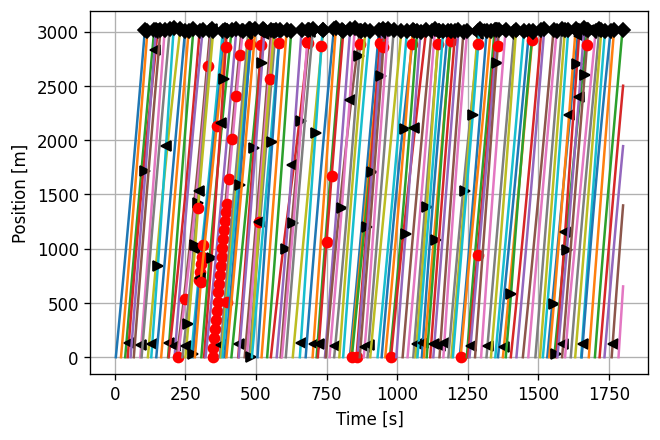

In [827]:
rec.plot('t','x')

In [828]:
travelling_time = Average_tt()
A_tt = sum(travelling_time) / len(travelling_time)
print('Average Travelling Time =', A_tt)

Average Travelling Time = 97.77690144881927


In [829]:
Avg_speed_3 = l.totalLength()/A_tt
print('Average Speed', Avg_speed_3, 'm/s')

Average Speed 30.68209316870541 m/s


In [830]:
Throughput = throughput()
print('Throughput in cars/hours = ', Throughput)

Throughput in cars/hours =  261.8568894145476


In [831]:
Traffic_density = Throughput/Avg_speed_1
print('Traffic Density = ', Traffic_density)

Traffic Density =  7.886723470105824
